In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re,glob,os
# from collections import defaultdict
import dgutils
import json

# Notebook display options
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import dframe_tools as dtools
import plot_tools as ptools
import gen_resubmit as gensub

# Comment out for description of below modules
# dtools.help()
# ptools.help()
# gensub.help()

'''
Assign path of OUTPUT files and generate database
Options:
skip = int or float [int: number of line to skip, float: proportion to skip]
noenergy = 0 if you have energy estimator, 1 if you don't. 0: pick 9, 10th column 1: pick 0, 1st column
replace = 1 if you want to replace nan to zero. Be cautious to use it
'''

### If you import data from csv, put 1 here
is_csv = 1


#=========================================================================
if is_csv == 1:

    dbase = pd.read_csv('../data/SFphase_data.csv')
    dbase['filedic'] = dbase['filedic'].apply(lambda x: json.loads(x.replace("'", '"')))
    dbase['boxdims'] = dbase['boxdims'].apply(lambda x: [float(t) for t in x.strip('[').strip(']').split(',')])

else:
### from raw data
    path = '/home/sang/UVM/H4test/lindenset/'
    dbase = dtools.df_pimc(path, skip = 0, noenergy = 1, replace = 1)

dfdict = ptools.datadic(dbase)

dict_keys(['0.07,-101.0', '0.07,-103.0', '0.07,-99.0', '0.14,-101.0', '0.09,-101.0', '0.09,-105.0', '0.09,-91.0', '0.09,-103.0', '0.09,-96.0', '0.09,-93.0', '0.1,-101.0', '0.1,-88.0', '0.1,-91.0', '0.1,-98.0', '0.1,-93.0', '0.1,-100.0', '0.03,-101.0', '0.03,-103.0', '0.12,-101.0', '0.12,-88.0', '0.12,-91.0', '0.12,-95.0', '0.12,-96.0', '0.12,-98.0', '0.12,-94.0', '0.12,-100.0', '0.06,-101.0', '0.06,-103.0', '0.06,-99.0', '0.16,-91.0', '0.16,-95.0', '0.16,-87.0', '0.16,-93.0', '0.16,-85.0', '0.08,-101.0', '0.08,-103.0', '0.08,-96.0', '0.08,-99.0', '0.08,-106.0', '0.13,-101.0', '0.22,-81.0', '0.22,-86.0', '0.22,-84.0', '0.22,-82.0', '0.22,-83.0', '0.24,-81.0', '0.24,-76.0', '0.05,-101.0', '0.05,-103.0', '0.05,-99.0', '0.18,-87.0', '0.18,-90.0', '0.18,-92.0', '0.18,-85.0', '0.18,-83.0', '0.04,-101.0', '0.04,-103.0', '0.04,-99.0', '0.2,-88.0', '0.2,-81.0', '0.2,-90.0', '0.2,-86.0', '0.2,-83.0', '0.28,-76.0', '0.15,-93.0'])


In [3]:
### plot style
plot_style = {'notebook':'../include/notebook.mplstyle','sans':'../include/sans_NC.mplstyle'}
plt.style.reload_library()
plt.style.use(plot_style['sans'])
figsize = plt.rcParams['figure.figsize']

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# setup a possible custom font path
from matplotlib import font_manager
def what_font_path (filename):
    for p in font_manager.findSystemFonts(fontpaths=None, fontext="ttf"):
        if p.find(filename) != -1:
            return p

font_path,bold_font_path = '.','.'
if 'LOCAL_FONT_PATH' in os.environ:
    font_path = os.environ['LOCAL_FONT_PATH'] + os.path.sep + 'HelveticaNeue/HelveticaNeue-Light-08.ttf'
    bold_font_path = os.environ['LOCAL_FONT_PATH'] + os.path.sep + 'HelveticaNeue/HelveticaNeue-Bold-02.ttf'
else:
    # local path (custom)
    font_path = what_font_path('HelveticaNeue-Light-08')
    bold_font_path = what_font_path('HelveticaNeue-Bold-02')

In [3]:
### Export data
# dbase.to_csv('../data/lindenset.csv',index=False)

In [4]:
def lin_ave(subset):
    if len(subset['strain'].unique()) != 1:
        print("the subset has more than one strain data")
        return None
    else:
        subset = subset.sort_values('totN', ascending=True)
        subset = subset.reset_index()

        totNlst = np.array(subset['totN'])

        lin_lst = []
        dz_lst = []

        for idx, row in subset.iterrows():
            file = row['filedic']['lineardensity'] #file location
            with open(file,'r') as lines:
                header = lines.readline()
                header = lines.readline()
            ngridsep = int(header.split(' ')[-1])
            dz = float(header.split(' ')[-4])
            linData = np.genfromtxt(file, skip_header=2,deletechars="") #read data
            linave = np.mean(linData, axis=0)
            lin_lst.append(linave)
            dz_lst.append(dz)
            
        return totNlst, lin_lst, dz_lst

In [5]:
target = dbase[(dbase['strain']==0.15)&(dbase['mu']==-93)&(dbase['totN']==64)&(dbase['T']==0.6)]

In [6]:
totNlst, lin_lst, dz_lst = lin_ave(target)
lx, ly, lz = target['boxdims'].iloc[0]

In [7]:
from scipy import interpolate
x = np.arange(0,10-dz_lst[0],dz_lst[0])
y = np.array(lin_lst[0])*dz_lst[0]*lx*ly/target['n'].iloc[0]
f = interpolate.interp1d(x, y, kind='cubic')

In [8]:
len(np.arange(0,2,dz_lst[0]))
x[20]

1.980198

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica Neue


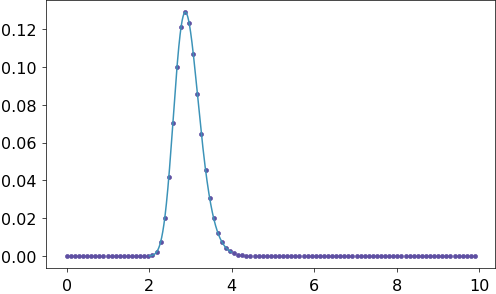

In [9]:
xnew = np.linspace(2, 4, 10000)
ynew = f(xnew)   # use interpolation function returned by `interp1d`
plt.plot(x, y, 'o', xnew, ynew, '-')

In [10]:
ymax = max(ynew)
halfmax = []
for i, yv in enumerate(ynew):
    if yv >= ymax/2:
        print(xnew[i], yv)
        halfmax.append(round(xnew[i],6))
        break
for i, yv in enumerate(ynew[::-1]):
    if yv >= ymax/2:
        print(xnew[-i], yv)
        halfmax.append(round(xnew[-i],6))
        break

2.5546554655465545 0.06453797426944141
3.267126712671267 0.06452839253345685


In [11]:
halfmax

[2.554655, 3.267127]

Text(0, 0.5, 'Linear Density (${\\rm \\AA}^{-1}$)')

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive


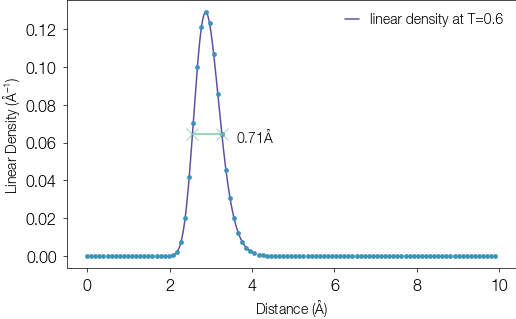

In [12]:
# totNlst, lin_lst, dz_lst = lin_ave(target)
# lx, ly, lz = target['boxdims'].iloc[0]

plt.style.reload_library()
fig = plt.figure('fig')
dgutils.fonts.set_custom_font(font_path)
plt.plot(xnew, ynew, '-', label=f'linear density at T=0.6')
plt.plot(np.arange(0,10-dz_lst[0],dz_lst[0]) ,np.array(lin_lst[0])*dz_lst[0]*lx*ly/target['n'].iloc[0],
         'o',)
plt.plot(halfmax, [ymax/2, ymax/2], "x-", ms = 6)
plt.text(3.6,0.06,str(round(halfmax[1]-halfmax[0],2))+r'${\rm \AA}$')
# for i in range(len(lin_lst)):
#     print(totNlst[i])
#     plt.plot(np.arange(0,10-dz_lst[i],dz_lst[i]) ,lin_lst[i], label=f'size={totNlst[i]}')
plt.legend()
plt.xlabel('Distance'+r' (${\rm \AA}$)')
plt.ylabel('Linear Density' +r' (${\rm \AA}^{-1}$)')
# fig.savefig('../figures/linden15-93.pdf')

In [13]:
sum(lin_lst[0]*dz_lst[0]*lx*ly/target['n'].iloc[0])

0.9989770725523296